In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, ReLU, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from PIL import ImageFont
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Імпортуємо CIFAR-10 датасет із Keras
from tensorflow.keras.datasets import cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
print('Shape of the Dataset')
print('==================================')
print('X_train Shape: {}'.format(X_train.shape))
print('-------------------------------------')
print('X_test Shape: {}'.format(X_test.shape))
print('-------------------------------------')
print('Y_train Shape: {}'.format(Y_train.shape))
print('-------------------------------------')
print('Y_test Shape: {}'.format(Y_test.shape))

Shape of the Dataset
X_train Shape: (50000, 32, 32, 3)
-------------------------------------
X_test Shape: (10000, 32, 32, 3)
-------------------------------------
Y_train Shape: (50000, 1)
-------------------------------------
Y_test Shape: (10000, 1)


In [3]:
# Нормалізація
X_train = X_train/255
X_test = X_test/255

# One-Hot-Encoding
Y_train_en = to_categorical(Y_train,10)
Y_test_en = to_categorical(Y_test,10)

In [13]:
class_names = {
    0: 'Літак',
    1: 'Автомобіль',
    2: 'Птах',
    3: 'Кіт',
    4: 'Олень',
    5: 'Собака',
    6: 'Жаба',
    7: 'Кінь',
    8: 'Корабель',
    9: 'Вантажівка',
}

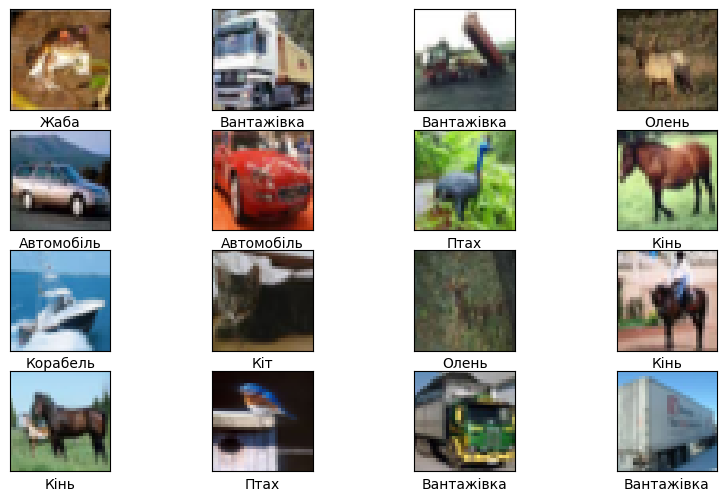

In [6]:
class_n = ['Літак', 'Автомобіль', 'Птах', 'Кіт', 'Олень',
               'Собака', 'Жаба', 'Кінь', 'Корабель', 'Вантажівка']

plt.figure(figsize=(10,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[Y_train[i][0]])
plt.show()

In [6]:
def evaluation(model):
  # Оцінка моделі
  evaluation = model.evaluate(X_test, Y_test_en)
  print(f'Test Loss: {evaluation[0]}')
  print(f'Test Accuracy: {evaluation[1]}')
  print(f'Test Precision: {evaluation[2]}')
  print(f'Test Recall: {evaluation[3]}')

  evaluation = model.evaluate(X_train, Y_train_en)
  print(f'Train Loss: {evaluation[0]}')
  print(f'Train Accuracy: {evaluation[1]}')
  print(f'Train Precision: {evaluation[2]}')
  print(f'Train Recall: {evaluation[3]}')

In [7]:
def plotloss(history):
    # Графіки метрик моделі
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Loss Train', 'Loss Validation', 'Accuracy Train', 'Accuracy Validation'])
    plt.show()

#### Дострокова Зупинка (Early Stopping)

Дострокова зупинка — це метод регуляризації, використовуваний для запобігання перенавчанню моделі шляхом припинення тренування, якщо валідаційна втрата не покращується протягом певної кількості епох.

- **`EarlyStopping(monitor='val_loss', patience=10)`**: Створює об'єкт EarlyStopping, який слідкує за валідаційною втратою (`val_loss`) і зупиняє тренування, якщо не спостерігається поліпшення протягом 10 епох (`patience=10`). Це допомагає запобігти зайвому тренуванню моделі

In [8]:
# Визначення зворотньої відповіді для дострокової зупинки
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## Почнемо з дуже простої моделі

Модель **Sequential** дозволяє будувати модель шар за шаром у послідовному порядку. Це означає, що кожен шар має вхідні дані лише з попереднього шару та виводить дані наступному шару без будь-яких розгалужень (тобто кожен шар має рівно один вхідний шар і один вихідний шар).

Кожен із шарів у моделі грає певну роль у процесі навчання глибокої нейронної мережі. Ось короткий огляд кожного типу шару:

#### Conv2D (Конволюційний шар)
- **Conv2D** є основним шаром для операцій з конволюцією на 2D зображеннях. Він автоматично вчиться виявляти корисні ознаки (наприклад, краї, текстури) у зображеннях за допомогою невеликих "фільтрів", які переміщаються по всьому зображенню. Параметри таких фільтрів адаптуються під час навчання, що дозволяє моделі ефективно виявляти важливі ознаки для задачі.
- У yашому випадку, `Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))` означає конволюційний шар із 32 фільтрами розміром 3x3, функцією активації ReLU, призначений для обробки вхідних зображень розміром 32x32 пікселів з 3 кольоровими каналами (RGB).

#### MaxPooling2D (Шар пулінгу)
- **MaxPooling2D** зменшує розмір вхідних ознак шляхом вибору максимального значення з певних областей вхідних даних. Це допомагає зменшити обчислювальні вимоги та кількість параметрів, зберігаючи при цьому найважливіші ознаки.
- Наприклад, `MaxPooling2D(pool_size=(2, 2))` вибирає максимальне значення з кожного квадрату 2x2 у вхідних даних, тим самим зменшуючи їх розміри вдвічі.

#### Flatten (Вирівнюючий шар)
- **Flatten** перетворює багатовимірний вхід у одновимірний масив, що дозволяє вхідним даним з конволюційних та пулінгових шарів бути використаними повнозв'язними шарами.
- Цей шар не має параметрів для навчання; він просто змінює форму даних.

#### Dense (Повнозв'язний шар)
- **Dense** є стандартним повнозв'язним шаром, де всі вхідні нейрони з'єднані з кожним нейроном у цьому шарі. Цей тип шару часто використовується для класифікації та регресії.
- Наприклад, `Dense(128, activation='relu')` створює повнозв'язний шар із 128 нейронами та функцією активації ReLU. `Dense(10, activation='softmax')` створює вихідний шар для клас

### Компіляція Моделі

Компіляція моделі є важливим кроком у процесі побудови нейронної мережі, який підготовлює модель до тренування. Це включає визначення оптимізатора, функції втрат та метрик для оцінки. Ось що означає кожен компонент у вашому виклику `compile`:

- **`optimizer='adam'`**: Використання оптимізатора Adam для коригування ваг на основі градієнтів для мінімізації функції втрат. Adam є популярним вибором, оскільки він автоматично регулює швидкість навчання та добре працює у багатьох сценаріях.

- **`loss='categorical_crossentropy'`**: Використання категорійної перехресної ентропії як функції втрат для багатокласової класифікації. Ця функція втрат вимірює різницю між передбаченими ймовірностями та фактичними мітками класів, ідеально підходить для задач, де кожен вхід належить рівно одному класу.

- **`metrics=['accuracy', Precision(), Recall()]`**: Використання точності, точності та повноти як метрик для моніторингу під час тренування та валідації моделі. Точність допомагає оцінити загальну ефективність моделі, в той час як точність та повнота надають більш детальний вигляд на її продуктивність у випадках позитивного класу.

- **`run_eagerly=True`**: Змушує модель виконуватися в режимі жадібного виконання (eager execution), що може бути корисно для дебагінгу, дозволяючи крок за кроком прослідковувати виконання коду, але це може сповільнити процес тренування.

In [17]:
# Ініціалізація моделі
model_simple = Sequential()

# Додавання одного конволюційного шару
model_simple.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

# Додавання шару пулінгу
model_simple.add(MaxPooling2D(pool_size=(2, 2)))

# Вирівнювання даних перед повнозв'язним шаром
model_simple.add(Flatten())

# Додавання повнозв'язного шару
model_simple.add(Dense(128, activation='relu'))

# Вихідний шар для класифікації на 10 класів
model_simple.add(Dense(10, activation='softmax'))

# Компіляція моделі
# model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_simple.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()],
              run_eagerly=True)

# Виведення підсумку моделі
model_simple.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 7200)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               921728    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 923914 (3.52 MB)
Trainable params: 923914 (3.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [20]:
# Навчаємо модель
history = model_simple.fit(X_train, Y_train_en, epochs=2, verbose=1,
                    validation_data=(X_test, Y_test_en), callbacks=[early_stopping])

Epoch 1/2
1563/1563 [==============================] - 167s 107ms/step - loss: 0.7202 - accuracy: 0.7476 - precision: 0.8307 - recall: 0.6655 - val_loss: 1.0728 - val_accuracy: 0.6399 - val_precision: 0.7207 - val_recall: 0.5675
Epoch 2/2
1563/1563 [==============================] - 165s 105ms/step - loss: 0.6692 - accuracy: 0.7657 - precision: 0.8399 - recall: 0.6915 - val_loss: 1.0817 - val_accuracy: 0.6396 - val_precision: 0.7182 - val_recall: 0.5649


In [12]:
# Вибір тестового зображення
test_image = X_test[1]  # Вибираємо перше зображення з тестового набору
test_image = np.expand_dims(test_image, axis=0)  # Розширюємо розміри, щоб відповідати формі вхідного шару моделі
# Робимо передбачення
prediction = model_simple.predict(test_image)
predicted_class = np.argmax(prediction)

1/1 [==============================] - 0s 28ms/step


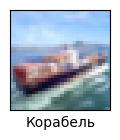

In [13]:
plt.figure(figsize=(10,6))
plt.subplot(4,4,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_test[1])
plt.xlabel(class_names[predicted_class])
plt.show()

1/1 [==============================] - 0s 25ms/step


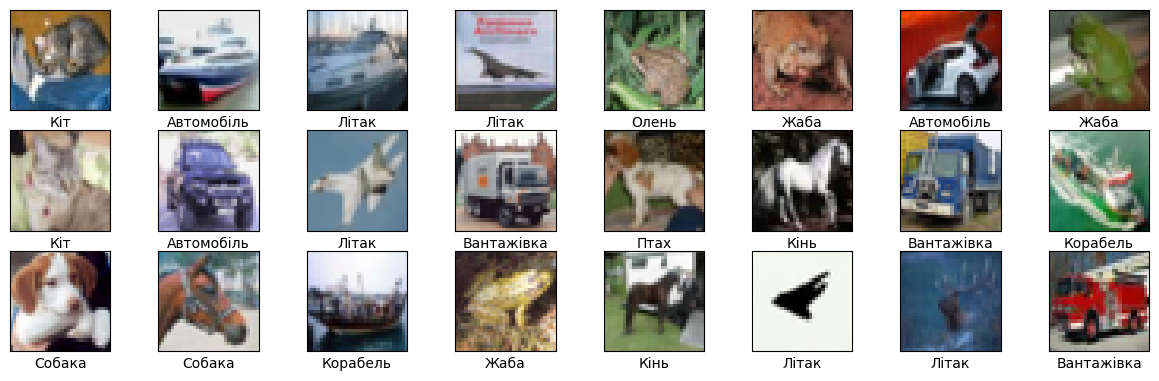

In [21]:
# Поглянемо на класифікацію перших 24  зображень  у тестовому наборі
plt.figure(figsize=(15,6))
for i in range(24):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    test_image = X_test[i]
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model_simple.predict(test_image)
    predicted_class = np.argmax(prediction)
    plt.xlabel(class_names[predicted_class])
plt.show()

In [17]:
evaluation(model_simple)

313/313 [==============================] - 11s 35ms/step - loss: 1.1309 - accuracy: 0.5998 - precision: 0.7465 - recall: 0.4536
Test Loss: 1.1308770179748535
Test Accuracy: 0.5997999906539917
Test Precision: 0.7465437650680542
Test Recall: 0.4535999894142151
1563/1563 [==============================] - 58s 37ms/step - loss: 1.0304 - accuracy: 0.6405 - precision: 0.7912 - recall: 0.4855
Train Loss: 1.0303984880447388
Train Accuracy: 0.6404600143432617
Train Precision: 0.7911736965179443
Train Recall: 0.48548001050949097


#### Врата (Loss)
-  Втрата — це кількісна міра різниці між передбаченими моделлю результатами та фактичними (істинними) даними. Менша втрата вказує на краще навчання моделі, оскільки це свідчить про те, що передбачення моделі близькі до істинних значень.
- Втрата на **тренувальному наборі** трохи нижча, ніж на **тестовому**, що є нормальним, оскільки модель оптимізується під тренувальний набір. Різниця між тренувальною та тестовою втратою не є значною, що свідчить про відсутність сильного перенавчання.

#### Точність (Accuracy)
- **Тестова точність** становить близько **59.98%**, тоді як **тренувальна точність** — приблизно **64.05%**. Це вказує на те, що модель досить добре узагальнюється на невидимих даних, але загальний рівень точності може бути не задовільним для деяких застосувань. Розрив між тренувальною та тестовою точністю не є дуже великим, що свідчить про відсутність значного перенавчання.

#### Точність (Precision)
- **Тестова точність** має вищий показник (**74.65%**) порівняно з **тренувальною точністю** (**79.12%**). Вища точність вказує на меншу кількість помилково позитивних результатів. Це добре, оскільки це означає, що коли модель передбачає наявність класу, вона має велику ймовірність бути правильною у своєму передбаченні.

#### Повнота (Recall)
- **Тестова повнота** значно нижча (**45.36%**) порівняно з **тренувальною повнотою** (**48.55%**). Низька повнота означає, що модель пропускає значну кількість справжніх позитивних випадків, тобто багато відповідей класу не вдається виявити.

#### Загальна Оцінка
- Модель має помірну точність, високу точність та низьку повноту. Низька повнота може бути критичною для задач, де важливо ідентифікувати якомога більше справжніх позитивних випадків (наприклад, у медичних застосуваннях).
- Відсутність значного перенавчання є позитивним аспектом, але загальна продуктивність моделі може бути недостатньою для деяких застосувань через відносно низьку точність та повноту.


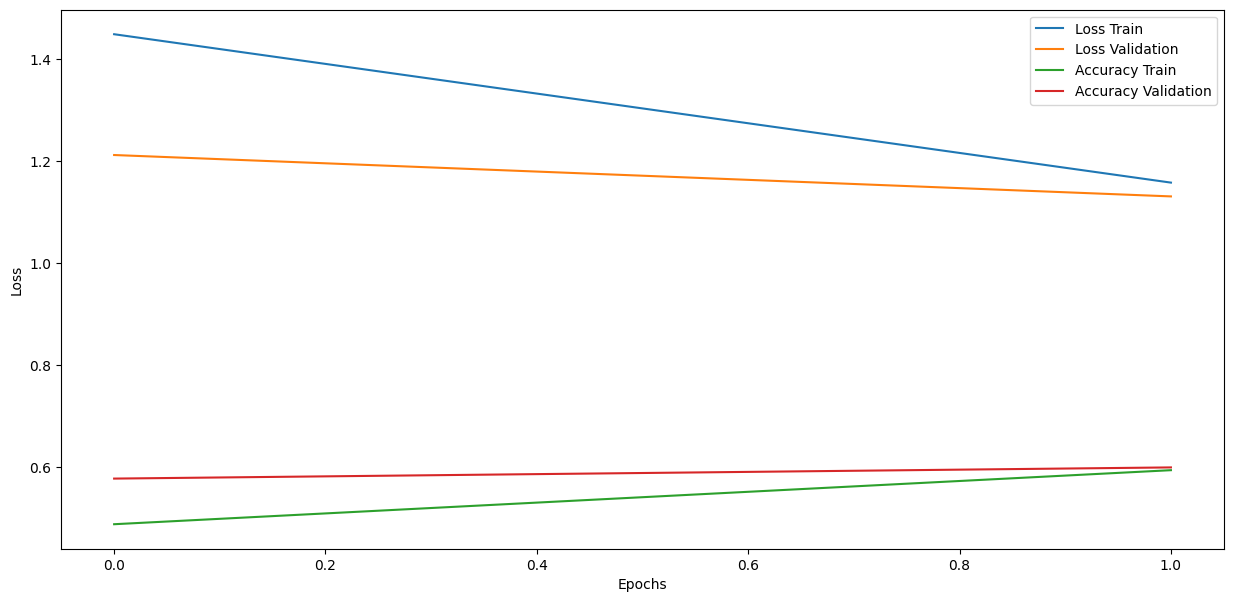

In [18]:
plotloss(history)

## Спробуємо навчити модель на 5 епохах, щоб підвищити точність класифікації

Epoch 1/5
1563/1563 [==============================] - 72s 46ms/step - loss: 1.4316 - accuracy: 0.4935 - precision_3: 0.7246 - recall_3: 0.2557 - val_loss: 1.2157 - val_accuracy: 0.5774 - val_precision_3: 0.7413 - val_recall_3: 0.3796
Epoch 2/5
1563/1563 [==============================] - 71s 45ms/step - loss: 1.1407 - accuracy: 0.5993 - precision_3: 0.7534 - recall_3: 0.4305 - val_loss: 1.1213 - val_accuracy: 0.6125 - val_precision_3: 0.7457 - val_recall_3: 0.4540
Epoch 3/5
1563/1563 [==============================] - 70s 45ms/step - loss: 1.0182 - accuracy: 0.6444 - precision_3: 0.7748 - recall_3: 0.5060 - val_loss: 1.0831 - val_accuracy: 0.6195 - val_precision_3: 0.7519 - val_recall_3: 0.4777
Epoch 4/5
1563/1563 [==============================] - 68s 44ms/step - loss: 0.9330 - accuracy: 0.6731 - precision_3: 0.7885 - recall_3: 0.5533 - val_loss: 1.0711 - val_accuracy: 0.6260 - val_precision_3: 0.7409 - val_recall_3: 0.5103
Epoch 5/5
313/313 [==============================] - 8s 27ms

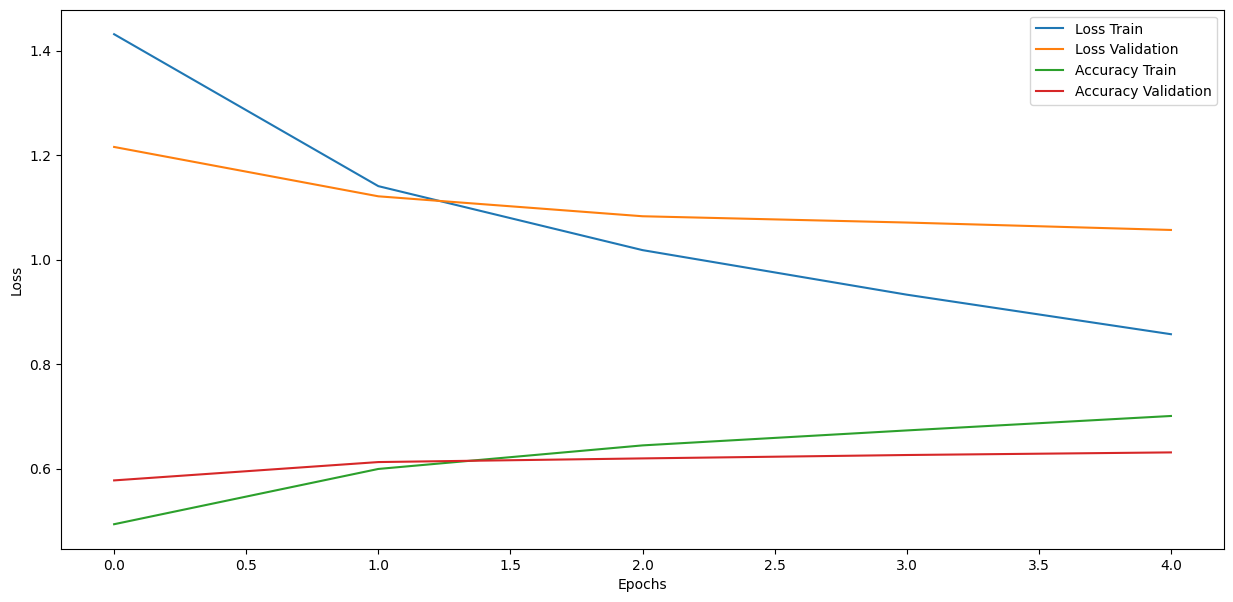

In [18]:
# Fit the model with early stopping
history = model_simple.fit(X_train, Y_train_en, epochs=5, verbose=1,
                    validation_data=(X_test, Y_test_en), callbacks=[early_stopping])

evaluation(model_simple)

plotloss(history)

### Метрики

- **Втрата (Loss)**:
  - Тренувальна втрата зменшується з кожною епохою, що свідчить про те, що модель продовжує вчитися і оптимізувати свої параметри.
  - Валідаційна втрата також зменшується, але не так стрімко, як тренувальна. Це може вказувати на потенційну здатність моделі до узагальнення, але розрив між тренувальною та валідаційною втратою слід уважно спостерігати, оскільки великий розрив може свідчити про перенавчання.

- **Точність (Accuracy)**:
  - Тренувальна точність постійно зростає, що є позитивним знаком.
  - Валідаційна точність зростає, але знову-таки, повільніше, ніж тренувальна. Тренувальна і валідаційна точність розходяться, що може бути ознакою початку перенавчання.

- **Точність і Повнота**:
  - Зі збільшенням числа епох, якщо точність та повнота на тестових даних не покращуються пропорційно до тренувальних даних, це може бути ознакою того, що модель може не добре узагальнювати на нових даних.

### Висновки з графіка

- Лінії тренувальної та валідаційної втрати показують очікуваний тренд зниження, проте втрата на валідації зменшується повільніше, це може вказувати на те, що може знадобитися подальша регуляризація або зміна тренувальної стратегії, щоб забезпечити краще узагальнення.
- Лінії тренувальної та валідаційної точності розходяться, що може бути ранньою ознакою перенавчання, хоча розрив не є дуже значним.


1/1 [==============================] - 0s 21ms/step


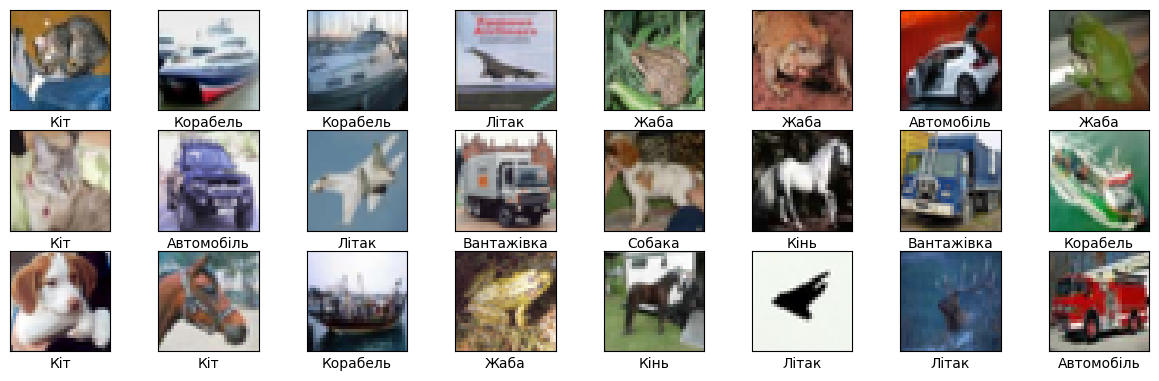

In [19]:
# Поглянемо на класифікацію перших 24 зображень у тестовому наборі
plt.figure(figsize=(15,6))
for i in range(24):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    test_image = X_test[i]
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model_simple.predict(test_image)
    predicted_class = np.argmax(prediction)
    plt.xlabel(class_names[predicted_class])
plt.show()

## Побудуємо складнішу модель

Додаємо два нові шари:

In [9]:
model = Sequential()
model.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', Precision(), Recall()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        65600     
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                      

Epoch 1/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.9368 - accuracy: 0.6729 - precision_1: 0.7817 - recall_1: 0.5704 - val_loss: 0.8415 - val_accuracy: 0.7100 - val_precision_1: 0.7974 - val_recall_1: 0.6354
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7569 - accuracy: 0.7403 - precision_1: 0.8217 - recall_1: 0.6648 - val_loss: 0.8159 - val_accuracy: 0.7146 - val_precision_1: 0.7981 - val_recall_1: 0.6447
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.6417 - accuracy: 0.7826 - precision_1: 0.8485 - recall_1: 0.7225 - val_loss: 0.9540 - val_accuracy: 0.7050 - val_precision_1: 0.7771 - val_recall_1: 0.6584
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.5562 - accuracy: 0.8115 - precision_1: 0.8661 - recall_1: 0.7631 - val_loss: 0.5748 - val_accuracy: 0.8047 - val_precision_1: 0.8598 - val_recall_1: 0.7577
Epoch 5/10
1563/1563 [==============================] - 

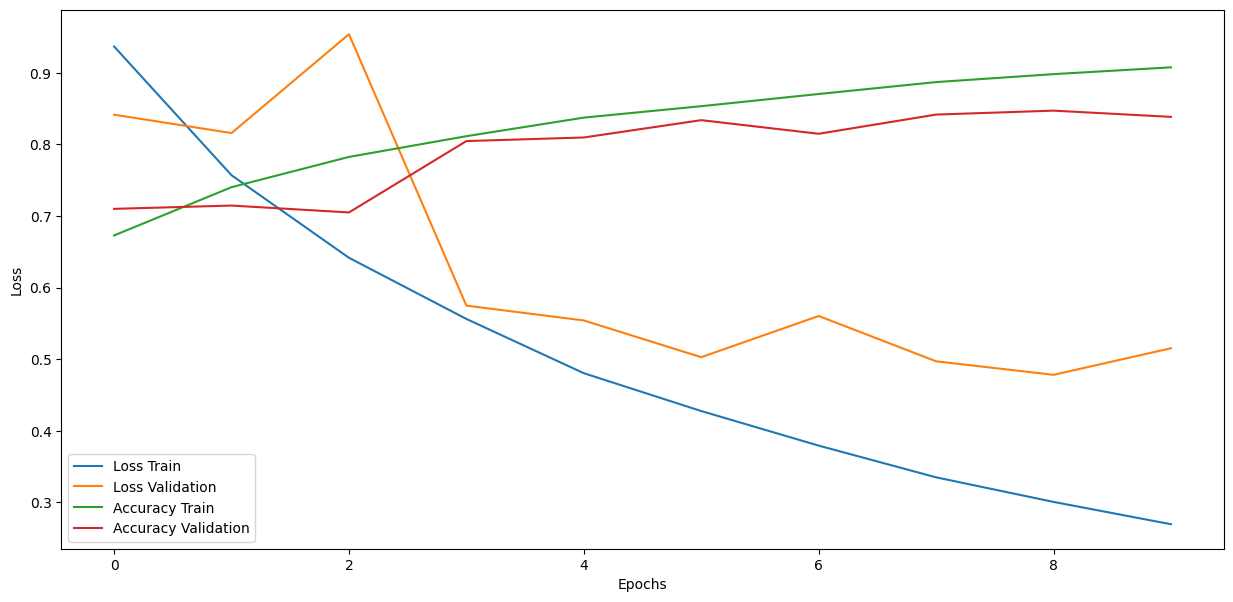

In [11]:
history = model.fit(X_train, Y_train_en, epochs=10, verbose=1,
                    validation_data=(X_test, Y_test_en), callbacks=[early_stopping])

evaluation(model)

plotloss(history)

### Метрики:

- **Тренувальна втрата (Train Loss)** значно знизилася до **0.1645**, що вказує на дуже ефективне навчання на тренувальному наборі даних.
- **Тренувальна точність (Train Accuracy)** зросла до **94.49%**, що свідчить про високу здатність моделі правильно класифікувати зображення на тренувальному наборі.
- **Тренувальна точність (Train Precision)** та **тренувальна повнота (Train Recall)** також високі, що показує, що модель ефективно визначає позитивні випадки та забезпечує хороше балансування між чутливістю та специфічністю.

Однак є суттєва різниця між тренувальними та тестовими метриками:

- **Тестова втрата (Test Loss)** складає **0.5153**, що значно вище за тренувальну втрату.
- **Тестова точність (Test Accuracy)** на рівні **83.85%** є хорошою, але помітно нижчою за тренувальну точність.
- **Тестова точність (Test Precision)** та **тестова повнота (Test Recall)** також вищі, ніж тренувальні показники.

Ця розбіжність між тренувальними та тестовими метриками може бути ознакою перенавчання.

### Аналіз графіка:

На графіку ми бачимо, що:

- Лінія тренувальної втрати (синя) стабільно знижується, що свідчить про те, що модель ефективно навчається.
- Лінія валідаційної втрати (оранжева) вища та демонструє деяку волатильність. Вона покращується на першому етапі, але потім відбувається певне погіршення, що може вказувати на нестабільність моделі або початок перенавчання.
- Тренувальна точність (зелена) показує стабільне зростання.
- Валідаційна точність (червона) також зростає, але її піки і провали вказують на потенційну надмірну підгонку моделі до тренувального набору.



1/1 [==============================] - 0s 19ms/step


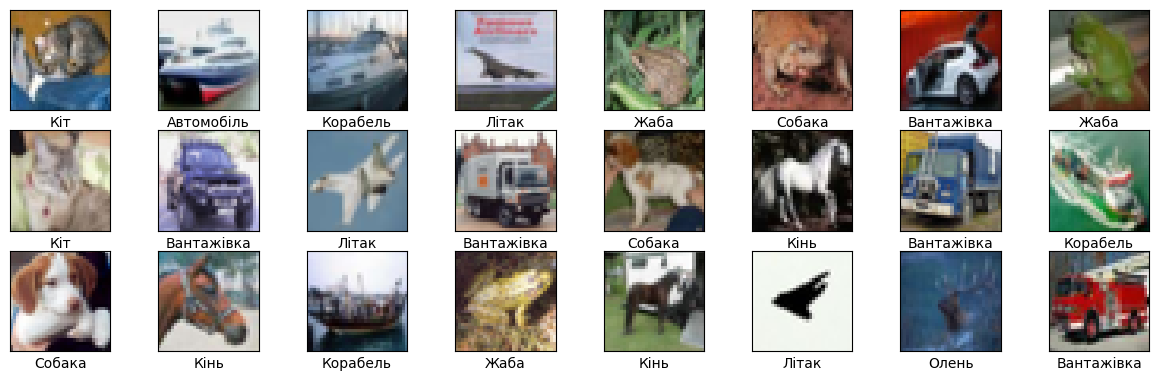

In [14]:
# Поглянемо на класифікацію перших 24 зображень у тестовому наборі
plt.figure(figsize=(15,6))
for i in range(24):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    test_image = X_test[i]
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    predicted_class = np.argmax(prediction)
    plt.xlabel(class_names[predicted_class])
plt.show()

## Застосуємо аугументацію

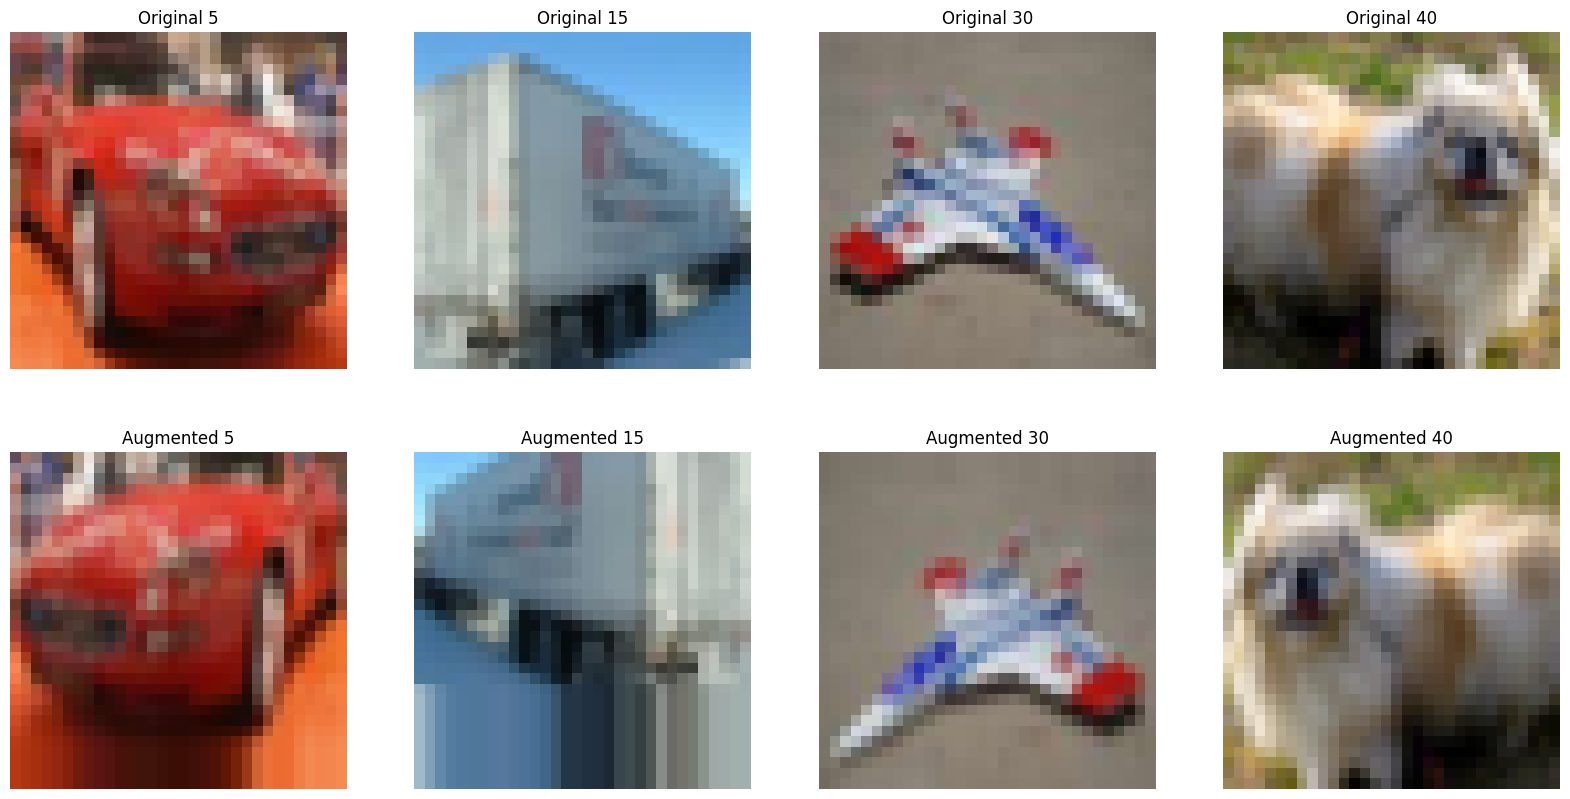

In [28]:
# Вибір чотирьох зображень з тренувального набору
indices = [5, 15, 30, 40]  # Припустимо, ми вибрали ці індекси
original_images = X_train[indices]

# Ініціалізація ImageDataGenerator
datagen = ImageDataGenerator(
    horizontal_flip=True, # Горизонтальне віддзеркалення
    width_shift_range=0.3, # Випадковий горизонтальний зсув
    fill_mode='nearest' # Стратегія заповнення новостворених пікселів, які можуть з'явитися після зсуву
)

# Візуалізація оригінальних та аугментованих зображень
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, img in enumerate(original_images):
    # Візуалізація оригінального зображення
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Original {indices[i]}")
    axes[0, i].axis('off')

    # Генерація аугментованого зображення
    augmented_img = next(datagen.flow(np.expand_dims(img, 0)))[0]

    # Візуалізація аугментованого зображення
    axes[1, i].imshow(augmented_img)
    axes[1, i].set_title(f"Augmented {indices[i]}")
    axes[1, i].axis('off')

plt.show()

#### Застосовуємо на всьому навчальному наборі

In [29]:
# Ініціалізація ImageDataGenerator
datagen = ImageDataGenerator(
    horizontal_flip=True,  # Горизонтальне віддзеркалення
    width_shift_range=0.1,  # Випадковий горизонтальний зсув
    fill_mode='nearest'  # Стратегія заповнення новостворених пікселів, які можуть з'явитися після зсуву
)

# Конфігурація генератора для тренувального набору даних
datagen.fit(X_train)

In [30]:
batch_size = 64  # Розмір пакету
epochs = 10  # Кількість епох

# Старт тренування з аугментацією даних
history = model_simple.fit(
    datagen.flow(X_train, Y_train_en, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, Y_test_en),
    steps_per_epoch=X_train.shape[0] // batch_size
)

Epoch 1/10
781/781 [==============================] - 75s 96ms/step - loss: 1.0144 - accuracy: 0.6459 - precision_3: 0.7667 - recall_3: 0.5249 - val_loss: 1.0414 - val_accuracy: 0.6424 - val_precision_3: 0.7454 - val_recall_3: 0.5372
Epoch 2/10
781/781 [==============================] - 75s 96ms/step - loss: 0.9859 - accuracy: 0.6568 - precision_3: 0.7745 - recall_3: 0.5375 - val_loss: 0.9852 - val_accuracy: 0.6587 - val_precision_3: 0.7656 - val_recall_3: 0.5472
Epoch 3/10
781/781 [==============================] - 71s 91ms/step - loss: 0.9733 - accuracy: 0.6592 - precision_3: 0.7750 - recall_3: 0.5377 - val_loss: 0.9578 - val_accuracy: 0.6632 - val_precision_3: 0.7692 - val_recall_3: 0.5581
Epoch 4/10
781/781 [==============================] - 71s 90ms/step - loss: 0.9471 - accuracy: 0.6698 - precision_3: 0.7824 - recall_3: 0.5535 - val_loss: 0.9760 - val_accuracy: 0.6643 - val_precision_3: 0.7559 - val_recall_3: 0.5746
Epoch 5/10
781/781 [==============================] - 74s 95ms/s

313/313 [==============================] - 8s 26ms/step - loss: 0.9647 - accuracy: 0.6627 - precision_3: 0.7558 - recall_3: 0.5854
Test Loss: 0.9646686315536499
Test Accuracy: 0.6626999974250793
Test Precision: 0.7558425068855286
Test Recall: 0.5853999853134155
1563/1563 [==============================] - 43s 27ms/step - loss: 0.7575 - accuracy: 0.7298 - precision_3: 0.8141 - recall_3: 0.6450
Train Loss: 0.7575202584266663
Train Accuracy: 0.7298200130462646
Train Precision: 0.8141425251960754
Train Recall: 0.6449800133705139


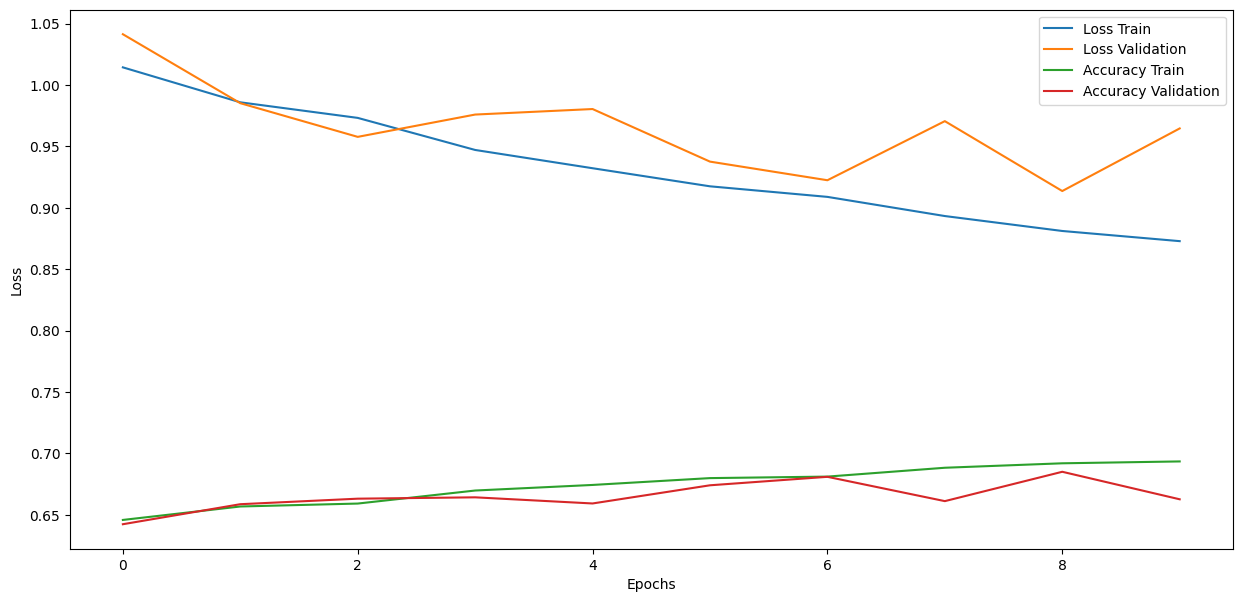

In [32]:
evaluation(model_simple)

plotloss(history)

### Метрики:
- **Тестова втрата (Test Loss)** становить **0.9647**, що дещо вище, ніж було б ідеально, але це може бути прийнятним для складних наборів даних, як CIFAR-10.
- **Тестова точність (Test Accuracy)** приблизно **66.27%**, що є показником середньої продуктивності. Враховуючи, що CIFAR-10 є складним набором даних із 10 класами, є можливість для покращення.
- **Тестова точність (Test Precision)** становить **75.58%**, це означає, що коли модель прогнозує певний клас, вона правильна більш ніж у трьох чвертях випадків.
- **Тестова повнота (Test Recall)** на рівні **58.54%** вказує на те, що модель пропускає багато істинно позитивних результатів, що може бути критичним для деяких застосувань.

### Графік:
- Лінія **втрати на тренуванні** (синя) показує загальний тренд на зниження, що є позитивним знаком, оскільки це свідчить, що модель з кожною епохою краще узгоджується з тренувальними даними.
- Лінія **втрати на валідації** (оранжева) демонструє волатильність, що може свідчити про надмірну підгонку або недостатню стабільність моделі при впорядкуванні на валідаційному наборі даних.
- Лінії точності для **тренувального** (зелена) та **валідаційного** (червона) наборів показують, що модель добре узгоджується з тренувальними даними, але її узагальнення на валідаційний набір не є стабільним.

### Загальна оцінка:
- На графіку видно, що втрата на валідації не постійно зменшується і має піки, що можуть вказувати на перенавчання або нестабільність тренування.
- Розрив між точністю на тренувальних та валідаційних даних також є ознакою можливого перенавчання.
- Цілком можливо, що аугментація даних, якщо вона виконувалася занадто агресивно, могла внести зайвий шум, що ускладнює навчання моделі.

1/1 [==============================] - 0s 22ms/step


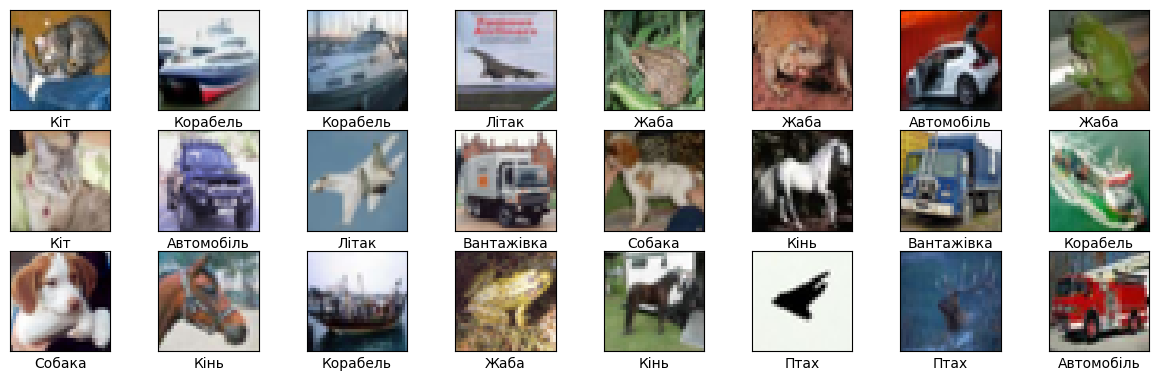

In [33]:
# Поглянемо на класифікацію перших 24 зображень у тестовому наборі
plt.figure(figsize=(15,6))
for i in range(24):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    test_image = X_test[i]
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model_simple.predict(test_image)
    predicted_class = np.argmax(prediction)
    plt.xlabel(class_names[predicted_class])
plt.show()

## Модифікована архітектура на основі ResNet

ResNet, що розшифровується як Residual Network, є революційною нейронною мережею, введеною Kaiming He та його командою у 2015 році. Вона стала відомою завдяки своїй здатності тренувати дуже глибокі нейронні мережі з сотнями або навіть тисячами шарів, подолавши проблему зникнення градієнтів, яка часто спостерігається в таких мережах. Центральною ідеєю ResNet є використання залишкових з'єднань (residual connections), які дозволяють градієнтам обходити один або декілька шарів.

### Як працює ResNet

У традиційних нейронних мережах кожен шар намагається вивчити пряму відповідь на задачу. В архітектурі ResNet замість цього кожен шар намагається вивчити лише залишкові відхилення від того, що було вже вивчено до нього. Іншими словами, якщо певний шар має на меті наблизити функцію H(x), він навчається апроксимувати F(x) = H(x) - x. Ця F(x) називається залишковою функцією. Такий підхід дозволяє градієнтам легше протікати через мережу, оскільки існує прямий шлях для протікання градієнтів між шарами.

### Адаптація нашої моделі під ResNet

У нашому оновленні моделі ми ввели елементи архітектури ResNet через використання залишкових блоків. Хоча це не є повноцінною архітектурою ResNet, це адаптація її ключової ідеї для покращення нашої моделі. Ось як ми це реалізували:

1. **Залишкові Блоки**: Ми створили функцію `make_residual_block`, яка будує залишковий блок. Кожен такий блок включає кілька конволюційних шарів і залишкове з'єднання, яке додає вхід блоку до його виходу. Це дозволяє моделі ефективно навчатися на глибоких шарах без втрати продуктивності.

2. **Глибинно-роздільні свердловини**: Хоча це не є частиною стандартної архітектури ResNet, ми використали глибинно-роздільні свердловини в наших залишкових блоках для зменшення обчислювального навантаження та кількості параметрів. Це дозволяє мережі бути більш ефективною при збереженні високої продуктивності.

3. **Інтеграція з Batch Normalization і ReLU**: Кожен конволюційний шар в залишкових блоках супроводжується Batch Normalization та активаційною функцією ReLU. Batch Normalization допомагає підтримувати розподіл вхідних даних шарів протягом тренування, що сприяє більш стабільному та швидкому навчанню. ReLU використовується для додавання нелінійностей між шарами, дозволяючи моделі вчитися складніші патерни.

4. **Залишкове з'єднання**: У кожному залишковому блоці вихід з попередніх шарів додається до виходу конволюційного блоку перед активацією ReLU. Це "пряме з'єднання" дозволяє градієнтам "плисти" назад через мережу без значних перешкод, значно знижуючи проблему зникнення або вибуху градієнтів, що особливо критично для глибоких мереж.

5. **Адаптація до CIFAR-10**: Наша адаптована під ResNet модель спроектована з урахуванням особливостей набору даних CIFAR-10, який складається з відносно невеликих за розміром зображень (32x32 пікселі). Ми почали з конволюційних шарів з великою кількістю фільтрів, щоб захопити детальні ознаки з маленьких зображень, а потім використовували залишкові блоки для поглиблення моделі без втрати продуктивності.

### Ця модифікована архітектура включає:

- Залишкові блоки для поліпшення потоку градієнтів під час навчання глибоких мереж.
- Глибинно-роздільні конволюції для зниження кількості параметрів та обчислювальної складності, зберігаючи при цьому здатність моделі вловлювати важливі ознаки.
- Дропаути з різними рівнями для різних шарів, що дозволяє більш ефективно регулювати перенавчання, адаптуючи рівень регуляризації в залежності від складності ознак на різних рівнях мережі.

In [41]:
def make_residual_block(filters, input_layer):
    # Початковий шар
    x = Conv2D(filters, (3, 3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Глибинно-роздільний конволюційний шар
    x = DepthwiseConv2D((3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Точковий шар (1x1 свердловина)
    x = Conv2D(filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Забезпечуємо, що вхідний шар має таку саму кількість каналів, як і x
    input_shape = input_layer.get_shape().as_list()
    residual_shape = x.get_shape().as_list()

    # Якщо форма входу не відповідає формі виходу, застосовуємо 1x1 конволюцію для коригування
    if input_shape[-1] != residual_shape[-1]:
        input_layer = Conv2D(filters, (1, 1), padding='same')(input_layer)

    # Залишкове з'єднання
    x = add([input_layer, x])
    return x

input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# Перший блок
x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

# Другий блок з залишковим з'єднанням
x = make_residual_block(64, x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Третій блок з залишковим з'єднанням
x = make_residual_block(128, x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.35)(x)

# Заключні шари
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Компіляція моделі
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Виведення підсумку моделі
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 32, 32, 64)           1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 32, 32, 64)           256       ['conv2d_27[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_28 (Conv2D)          (None, 32, 32, 64)           36928     ['batch_normalization_30[0

In [42]:
history = model.fit(
    datagen.flow(X_train, Y_train_en, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, Y_test_en),
    steps_per_epoch=X_train.shape[0] // batch_size
)

Epoch 1/10
781/781 [==============================] - 41s 42ms/step - loss: 1.6578 - accuracy: 0.4242 - precision_4: 0.5621 - recall_4: 0.2639 - val_loss: 2.5093 - val_accuracy: 0.2906 - val_precision_4: 0.2953 - val_recall_4: 0.2144
Epoch 2/10
781/781 [==============================] - 32s 41ms/step - loss: 1.1660 - accuracy: 0.5832 - precision_4: 0.7232 - recall_4: 0.4330 - val_loss: 2.6198 - val_accuracy: 0.5151 - val_precision_4: 0.5999 - val_recall_4: 0.4053
Epoch 3/10
781/781 [==============================] - 35s 44ms/step - loss: 1.0219 - accuracy: 0.6384 - precision_4: 0.7601 - recall_4: 0.5132 - val_loss: 2.3098 - val_accuracy: 0.5429 - val_precision_4: 0.6169 - val_recall_4: 0.4529
Epoch 4/10
781/781 [==============================] - 32s 41ms/step - loss: 0.9304 - accuracy: 0.6736 - precision_4: 0.7790 - recall_4: 0.5639 - val_loss: 1.9157 - val_accuracy: 0.5370 - val_precision_4: 0.5991 - val_recall_4: 0.4732
Epoch 5/10
781/781 [==============================] - 32s 41ms/s

313/313 [==============================] - 2s 6ms/step - loss: 0.7024 - accuracy: 0.7653 - precision_4: 0.8228 - recall_4: 0.7183
Test Loss: 0.7023563981056213
Test Accuracy: 0.7652999758720398
Test Precision: 0.8227949738502502
Test Recall: 0.7182999849319458
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6317 - accuracy: 0.7877 - precision_4: 0.8458 - recall_4: 0.7400
Train Loss: 0.631661057472229
Train Accuracy: 0.7877399921417236
Train Precision: 0.8458267450332642
Train Recall: 0.7399799823760986


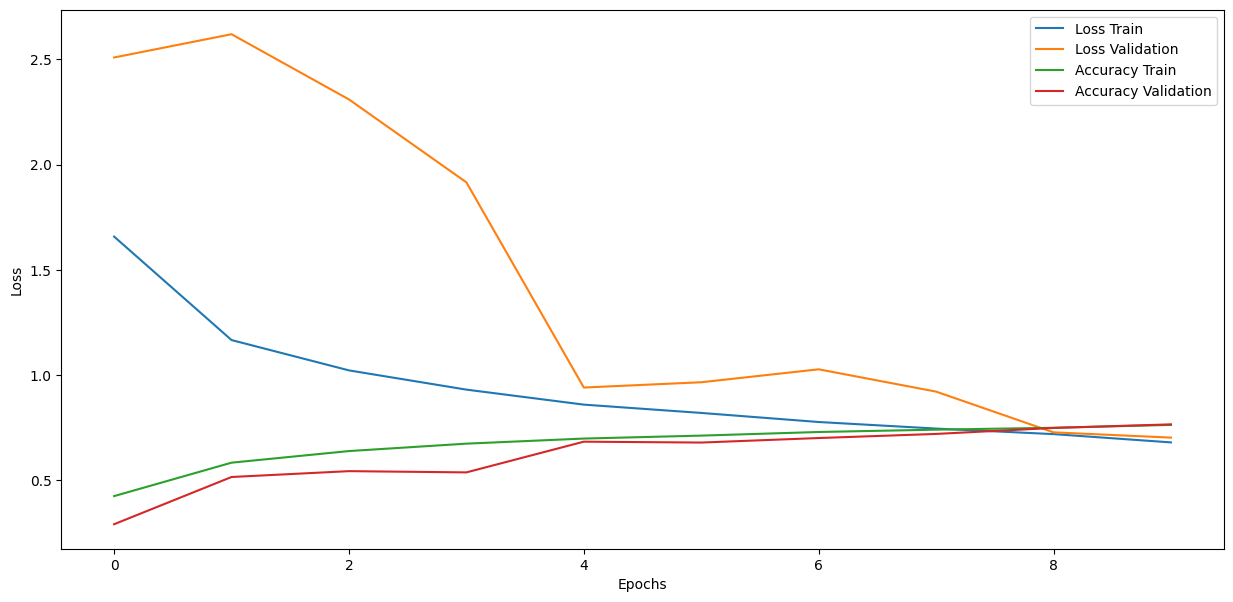

In [43]:
evaluation(model)

plotloss(history)

### Метрики:

- **Тестова втрата (Test Loss)** становить **0.7024**, що вище, ніж тренувальна втрата (**0.6317**), але не надто значно. Це вказує на потенційно хороше узагальнення, зважаючи на складність набору даних.
- **Тестова точність (Test Accuracy)** на рівні **76.53%** є відносно високою, особливо для набору даних як CIFAR-10, що має велику варіативність візуальних ознак між класами.
- **Тестова точність (Test Precision)** на рівні **82.28%** є досить високою, що свідчить про здатність моделі вірно класифікувати більшість позитивних зразків.
- **Тестова повнота (Test Recall)** становить **71.83%**, що вказує на те, що модель досить добре здатна ідентифікувати позитивні випадки серед різних класів.

### Графік:

Графік показує динаміку змін тренувальної та валідаційної втрати та точності протягом восьми епох:

- Лінія **тренувальної втрати** (синя) має загальний тренд на зниження, що вказує на ефективне навчання моделі.
- Лінія **валідаційної втрати** (оранжева) спочатку падає, але потім стабілізується та навіть показує невелике підвищення, що може вказувати на перенавчання або недостатнє узагальнення моделі.
- **Тренувальна точність** (зелена) зростає протягом усіх епох, хоч і з певними коливаннями.
- **Валідаційна точність** (червона) загалом зростає, але показує волатильність, особливо на останніх етапах, що може бути пов'язано із варіативністю аугментованих даних або різними характеристиками розподілу в тренувальних та валідаційних наборах.

### Загальна оцінка моделі:

Модель на основі ResNet, яка тренована на аугментованих даних, показує обіцяючі результати, але є потенціал для покращення. Зокрема, волатильність у валідаційній точності та втраті може вказувати на деякі проблеми:

- По-перше, модель може страждати від перенавчання, оскільки тренувальні показники вищі від тестових.
- По-друге, аугментація даних може бути занадто агресивною або не достатньо різноманітною, що призводить до перепідгонки моделі під тренувальний набір і погіршення узагальнення на валідаційний набір.


1/1 [==============================] - 0s 20ms/step


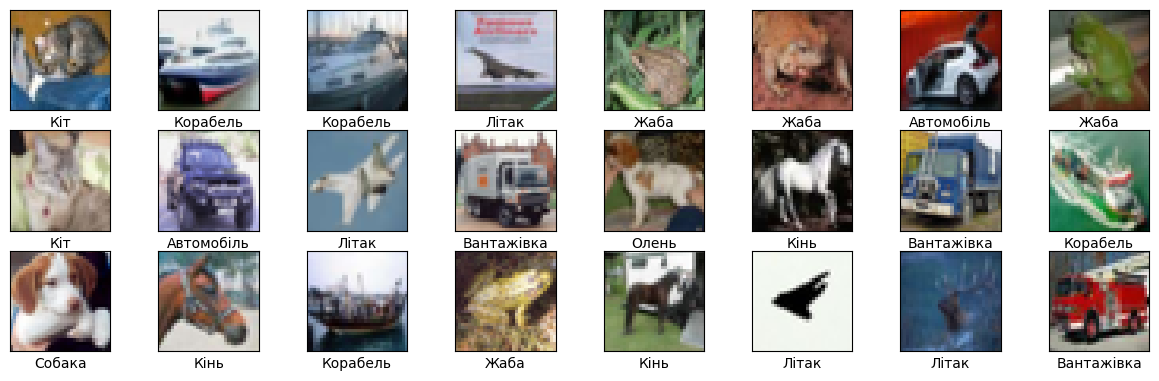

In [44]:
# Поглянемо на класифікацію перших 24 зображень у тестовому наборі
plt.figure(figsize=(15,6))
for i in range(24):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    test_image = X_test[i]
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    predicted_class = np.argmax(prediction)
    plt.xlabel(class_names[predicted_class])
plt.show()

### Висновки про продуктивність моделі:
**ResNet із тренуванням на аугментованих даних**:
    - Продемонструвала гіршу точність на тестовому наборі в порівнянні з простою моделлю Sequential.
    - Precision та recall на тестовому наборі також нижчі, що може свідчити про більші труднощі з класифікацією певних класів або зменшенням здатності до узагальнення.
    - Вища тестова втрата може бути результатом перенавчання або недостатньо ефективної аугментації даних.

### Причини, чому ResNet із аугментацією не стала кращою:
- Аугментація даних може внести додатковий шум у навчальний процес, особливо якщо вона занадто агресивна, не достатньо різноманітна або не відображає реальних сценаріїв, з якими модель зіткнеться під час використання.
- ResNet була розроблена для глибокого навчання, і використання такої складної архітектури може вимагати більше даних або більше часу для навчання, щоб досягти оптимального узагальнення.
- Якщо конфігурація шарів аугментації не ідеально відповідає задачі, це може зменшити продуктивність моделі.


### Спробуємо збільшити кількість тренувальних епох, щоб дати моделі більше простору для оптимізації

Epoch 1/30
781/781 [==============================] - 37s 47ms/step - loss: 0.6624 - accuracy: 0.7702 - precision_4: 0.8383 - recall_4: 0.7101 - val_loss: 0.8201 - val_accuracy: 0.7223 - val_precision_4: 0.7801 - val_recall_4: 0.6752
Epoch 2/30
781/781 [==============================] - 33s 42ms/step - loss: 0.6375 - accuracy: 0.7779 - precision_4: 0.8432 - recall_4: 0.7188 - val_loss: 0.8551 - val_accuracy: 0.7309 - val_precision_4: 0.7893 - val_recall_4: 0.6869
Epoch 3/30
781/781 [==============================] - 32s 41ms/step - loss: 0.6263 - accuracy: 0.7829 - precision_4: 0.8473 - recall_4: 0.7248 - val_loss: 0.6635 - val_accuracy: 0.7868 - val_precision_4: 0.8365 - val_recall_4: 0.7416
Epoch 4/30
781/781 [==============================] - 33s 42ms/step - loss: 0.6041 - accuracy: 0.7901 - precision_4: 0.8505 - recall_4: 0.7363 - val_loss: 0.6338 - val_accuracy: 0.8029 - val_precision_4: 0.8504 - val_recall_4: 0.7670
Epoch 5/30
781/781 [==============================] - 31s 40ms/s

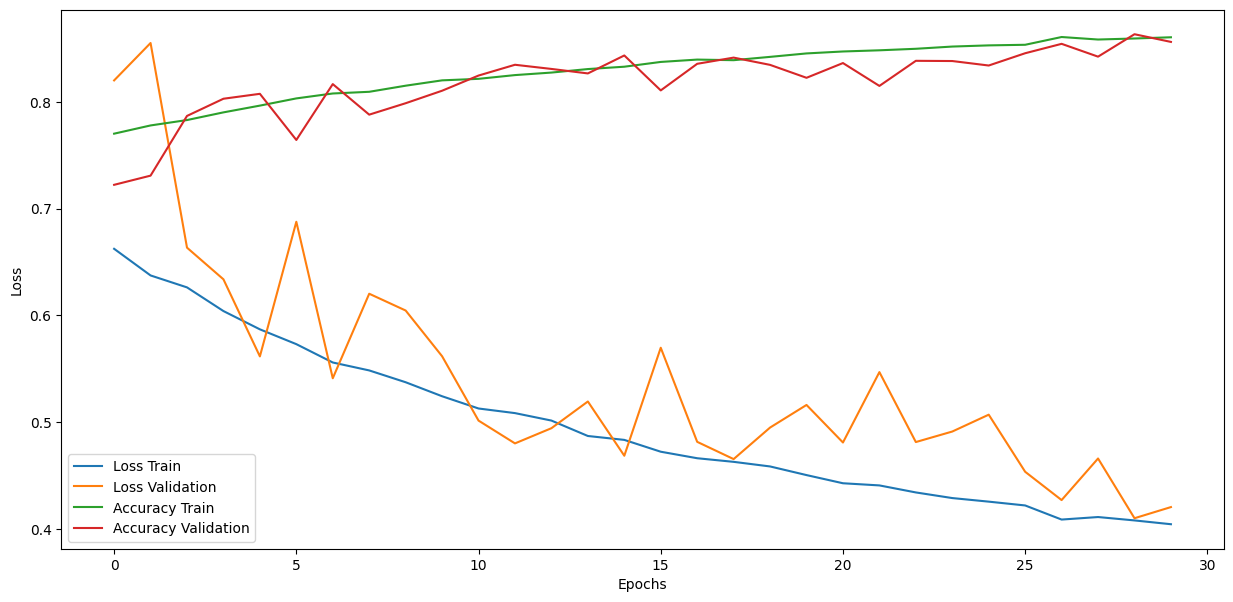

In [45]:
history = model.fit(
    datagen.flow(X_train, Y_train_en, batch_size=batch_size),
    epochs=30,
    validation_data=(X_test, Y_test_en),
    steps_per_epoch=X_train.shape[0] // batch_size
)

evaluation(model)

plotloss(history)

### Аналіз Покращень:
- Збільшення кількості епох з 10 до 30 значно покращило всі метрики продуктивності, як на тренувальному, так і на тестовому наборах.
- Втрата на тренувальному та тестовому наборах знизилася, що свідчить про те, що модель стала більш ефективною у класифікації зображень.
- Точність, precision і recall на обох наборах зросли, що вказує на зменшення помилкових позитивних та негативних класифікацій, а також на поліпшену здатність моделі розпізнавати різні класи зображень.
- Значне покращення в precision і recall вказує на збільшення здатності моделі коректно ідентифікувати позитивні класи та зменшити кількість пропущених позитивних випадків.
- Покращення точності на тестовому наборі до 85.61% є особливо значним, оскільки це вказує на високу здатність моделі до узагальнення на невидимих даних, яка є важливою для реального світу застосувань.


## Висновки

### Вплив конкретної архітектури та конфігурації шарів:

- **Архітектура моделі**: Складні моделі, такі як ResNet, здатні виявляти складні взаємозв'язки у великих наборах даних, але можуть страждати від перенавчання на менших наборах або без достатньої регуляризації.
- **Conv2D**: Конволюційні шари визначають, як модель може виявляти ознаки на різних рівнях абстракції. Велика кількість фільтрів та розміри ядра можуть бути налаштовані для різних типів зображень та задач. Великі ядра та більше фільтрів можуть виявляти більш складні ознаки, але також збільшують обчислювальну складність та ризик перенавчання.

- **MaxPooling2D**: Операції пулінгу допомагають зменшити розміри фічер-мап, забезпечуючи просторову інваріантність та знижуючи загальну кількість параметрів у моделі, що може сприяти кращому узагальненню.

- **Dropout**: Шари Dropout - це форма регуляризації, яка допомагає запобігти перенавчанню шляхом випадкового "вимкнення" деяких нейронів під час тренування. Це спонукає модель до того, щоб не покладатися занадто на будь-який один нейрон та сприяє розрідженості представлень.

- **BatchNormalization**: Шари BatchNormalization нормалізують вхідні дані кожного шару так, що вони мають стабільний розподіл. Це може прискорити тренування та забезпечити краще узагальнення, але також може вимагати додаткової настройки та експериментування з гіперпараметрами.


### З усіх моделей найкращими виявилися такі:

1. **Complex Sequential (10 епох):**
   - Висока тренувальна точність (**94.49%**) та низька втрата (**0.1645**), що свідчить про ефективне навчання на тренувальному наборі.
   - Висока тестова точність (**83.85%**) із порівняно низькою втратою (**0.5153**), а також високі значення precision (**86.67%**) та recall (**82.15%**), що вказує на добре узагальнення та баланс між виявленням позитивних зразків та збереженням низького рівня помилкових спрацьовувань.

2. **ResNet з аугментованими даними (30 епох):**
   - Висока тренувальна точність (**90.03%**) з низькою втратою (**0.2838**), що показує здатність моделі до вловлювання складних взаємозв'язків у даних.
   - Тестова точність (**85.61%**) вища, ніж у моделі Complex Sequential, із значно нижчою втратою (**0.4206**), що вказує на відмінне узагальнення. Високі значення precision (**88.64%**) та recall (**83.49%**) також вказують на те, що модель добре розпізнає позитивні зразки і має низький рівень помилкових негативних.

## Висновки:

- Модель **Complex Sequential** показує відмінні результати на тренувальному наборі та дуже хороші на тестовому, що робить її надійним вибором для завдань, де потрібна висока точність і узагальнення.
  
- Модель **ResNet**, навчена на аугментованих даних протягом більшої кількості епох, забезпечила краще узагальнення, що відображається у вищій точності та нижчій втраті на тестовому наборі. Також вона має кращу здатність до класифікації з більшою впевненістю (вищий precision і recall).

- **Архітектура ResNet** з аугментацією даних, ймовірно, краще справляється зі складностями набору даних CIFAR-10, забезпечуючи міцніше і консистентніше узагальнення. Це може бути пов'язано з тим, що ResNet здатна ефективно навчатися на більш глибоких рівнях представлення, що є важливим для комплексних наборів даних.

- Додаткові епохи навчання для моделі ResNet допомогли в узагальненні, підвищуючи точність та знижуючи втрату. Це вказує на те, що з додатковим тренуванням модель краще адаптувалася до складності набору даних CIFAR-10, змогла краще розпізнати ознаки та зменшити помилки як на тренувальному, так і на тестовому наборах.